In [1]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from pickle import dump, load
import os
# from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

# Última camada sem função de ativação --> crossentropy já aplica softmax
# ReLU em intermediárias
    def forward(self, x):
        for layer in self.linears[0:-1]:                   
            x = F.relu(layer(x))
        x = (self.linears[-1](x))
        return(x)

# # Aplicando função de ativação na última camada tbm
# ### Tentar mudar pra sigmoide se deixar a normalização de 0,1
#     def forward(self, x):
#         for layer in self.linears:                   
#             x = torch.sigmoid(layer(x))
# #             x = F.relu(layer(x))
#         return(x)

In [3]:
def nonRepeatedRandomInt(low, upper, N):
        import numpy as np
        import random
        
        numbers = np.arange(low, upper, 1)
        random.shuffle(numbers)
        shuffleNumbers = np.array(numbers)[0:int(N)]
                
        return shuffleNumbers

def createSurrogate(X):
    Xsur  = np.zeros_like(X)
    for i in range(X.shape[1]):
        Xsur[:,i] = X[nonRepeatedRandomInt(0, X.shape[0], X.shape[0]),i]
    return Xsur

def save_checkpoint(state, is_best, filename):
    if is_best:
        torch.save(state, filename)
#         print('*****Saved epoch: %d *****' % (state['epoch']))

In [96]:
def ls(p, y):
    py = (p.T).dot(y)
    covP = np.linalg.inv((p.T).dot(p))
    beta = covP.dot(py)
    return beta

def executeMFrols(p, y, pho, D, L=1, supress=False, mfrolsEngine='python'):
    import sys
    sys.path.insert(1, '/home/rnwatanabe/Dropbox/Nonlinear-System-Identification-and-Frequency-Analysis/')
    import frolsfunctions
    import gc
    
    p, y = reshapepymatrices(p, y, L)    
    s = 0
    ESR = 1.0
    l = -1*np.ones((p.shape[1]), dtype=np.int32, order='F')
    err = np.zeros((p.shape[1]), dtype=np.float64, order='F')
    A = np.zeros((p.shape[1], p.shape[1], p.shape[2]), dtype=np.float64, order='F')
    q = np.zeros_like(p)
    g = np.zeros((p.shape[2], p.shape[1]), dtype=np.float64, order='F')
    
    gc.collect()
    
    if mfrolsEngine == 'python':
        beta, l, M0 = mfrols(p, y, pho, s, ESR, l, err, A, q, g, verbose= not supress)
    if mfrolsEngine == 'fortran':
        if np.ndim(p) == 2:
            pTemp = np.zeros((np.shape(p)[0], np.shape(p)[1], 1), dtype=np.float64, order='F')
            pTemp[:, :, 0] = p
            p = pTemp
            M = p.shape[1]
            l = -1*np.ones((M), dtype=np.int32, order='F')
            err = np.zeros((M), dtype=np.float64, order='F')
            A = np.zeros((M, M, 1), dtype=np.float64, order='F')
            
            g = np.zeros((1, M), dtype=np.float64, order='F')
    
        if np.ndim(y) == 1:
            yTemp = np.zeros((np.shape(y)[0], 1))
            yTemp[:, 0] = y
            y = yTemp
        s = 1
        M = p.shape[1]
        K = p.shape[2]
        beta = np.zeros((M, K), np.float64, order='F')
        M0 = 0
        qs = np.copy(p)
        
        beta, M0 = frolsfunctions.frolsfunctions.mfrols(p, y, pho, s, ESR, l, err, 
                                                        A, qs, g, not supress, 
                                                        p.shape[0], M, K)
        l = l - 1
        beta = beta[0:M0,:]

    betatemp = np.zeros((p.shape[1],1))
    
    for i in range(M0):
        if (not supress): print(D[int(l[i])], np.mean(beta[i,:]))
        betatemp[int(l[i])] = np.mean(beta[i,:])

    beta = betatemp
    return beta

def mfrols(p, y, pho, s, ESR, l, err, A, q, g, verbose=False):
    '''
    Implements the MFROLS algorithm (see page 97 from Billings, SA (2013)).
        written by: Renato Naville Watanabe
        beta = mfrols(p, y, pho, s)
        Inputs:
          p: matrix of np.float64s, is the matrix of candidate terms.
          y: vector of np.float64s, output signal.
          pho: np.float64, stop criteria.
          s: integer, iteration step of the mfrols algorithm.
          l: vector of integers, indices of the chosen terms.M = np.shape(p)[1]; l = -1*np.ones((M))
          err: vector of np.float64s, the error reduction ratio of each chosen term. err = np.zeros((M))
          ESR: np.float64, the sum of the individual error reduction ratios. Initial value eual 1.
          A: matrix of np.float64s, auxiliary matrix in the orthogonalization process.
                  A = np.zeros((M,M,1))
          q: matrix of np.float64s, matrix with each column being the terms orthogonalized
                  by the Gram-Schmidt process. q = np.zeros_like(p)
          g: vector of np.float64s, auxiliary vector in the orthogonalization process.
                  g = np.zeros((1,M))
        Output:
          beta: vector of np.float64s, coefficients of the chosen terms.
          l: vector of integers, indices of the chosen terms
          M0: number of chosen terms
    '''
    

    if np.ndim(p) == 2:
        pTemp = np.zeros((np.shape(p)[0], np.shape(p)[1], 1))
        pTemp[:, :, 0] = p
        p = pTemp
        M = p.shape[1]
        l = -1*np.ones((M))
        err = np.zeros((M))
        A = np.zeros((M, M, 1))
        q = np.zeros_like(p)
        g = np.zeros((1, M))

    if np.ndim(y) == 1:
        yTemp = np.zeros((np.shape(y)[0], 1))
        yTemp[:, 0] = y
        y = yTemp

    M = p.shape[1]
    L = p.shape[2]
    gs = np.zeros((L, M))
    ERR = np.zeros((L, M))
    qs = np.copy(p)
    
    sigma = np.sum(y**2, axis=0)
    
    for m in range(M):
        if np.all(m!=l):
            ## The Gram-Schmidt method was implemented in a modified way,
            ## as shown in Rice, JR(1966)                
            for r in range(s):
                qs[:, [m], :] = qs[:, [m], :] - (np.sum(q[:, [r], :]*qs[:, [m], :], axis=0, keepdims=True)
                                                 /(np.sum(q[:, [r], :]*q[:, [r], :], axis=0, keepdims=True) + 1e-6)*q[:, [r], :])
            
            gs[:, [m]] = (np.sum(y*qs[:, m, :], axis=0, keepdims=True)/(np.sum(qs[:, m, :]*qs[:, m, :], axis=0, keepdims=True) + 1e-6)).T
            
            ERR[:, m] = (gs[:, m]**2*np.sum(qs[:, [m], :]*qs[:, [m], :], axis=0)/sigma)
            


    ERR_m = np.mean(ERR, axis=0)
        
    l[s] = np.where(ERR_m==np.nanmax(ERR_m))[0][0]
    err[s] = ERR_m[int(l[s])]
    
    r = np.arange(s)
    A[r, s, :] = np.sum(q[:, r, :]*p[:, [int(l[s])], :], axis=0)/(np.sum(q[:, r, :]*q[:, r, :], axis=0)+1e-6)
    A[s, s, :] = 1.0
    q[:, s, :] = qs[:, int(l[s]), :]
    g[:, s] = gs[:, int(l[s])]

    ESR = ESR - err[s]   

    ## recursive call

    if (err[s]>=pho and s<M-1):
        if verbose:
            print('term number', s)
            print('ERR', err[s])
            print(l[:s+1])
        s += 1
        del qs
        del gs
        beta, l, M0 = mfrols(p, y, pho, s, ESR, l, err, A, q, g, verbose=verbose)
    else:
        if verbose:
            print('term number', s)
            print('ERR', err[s])
            print(l[:s+1])
        s += 1  
        M0 = s              
        beta = np.empty((M0, L))
        for j in range(L):
            if s > 1:
                beta[:, j] = np.linalg.inv(np.squeeze(A[0:M0, 0:M0, j]))@np.transpose(g[j, 0:M0])
            else:
                beta[:, j] = (np.squeeze(A[0:M0, 0:M0,j])**-1)*g[j, 0:M0]
    return beta, l, M0

def reshapepymatrices(p, y, L):
    
    if len(p.shape) == 2:
        p = p.reshape(p.shape[0], p.shape[1], 1)
    m = int(np.floor(p.shape[0]/L))
    ptemp = np.zeros((m,p.shape[1],L*p.shape[2]), dtype=np.float64, order='F')
    ytemp = np.zeros((m,L*p.shape[2]), dtype=np.float64, order='F')
    for j in range(p.shape[2]):
        for i in range(L):
            ptemp[:,:,j*L+i] = p[m*i:m*(i+1),:, j]
            ytemp[:, j*L+i] = y[m*i:m*(i+1), j]
    pt = ptemp
    yt = ytemp
    return pt, yt

In [5]:
X_train_vali = np.load('X_train_valiBDS.npy')
y_train_vali_class = np.load('y_train_vali_classBDS.npy')
y_train_vali = np.load('y_train_valiBDS.npy')
X_test = np.load('X_testBDS.npy')
y_test_class = np.load('y_test_classBDS.npy')
y_test = np.load('y_testBDS.npy')
features_names = np.load('features_names.npy', allow_pickle=True)


# Divide em classes de acordo com a os quartis do dado de treino/vali
# quart = np.quantile(y_train_vali,[0.25, 0.5, 0.75])
# print(quart)
# y_train_vali_class = np.digitize(y_train_vali, quart)
# y_test_class = np.digitize(y_test, quart)
# print((y_train_vali_class).shape)
# print((y_test_class).shape)


In [6]:
# Create empty xlsx with header
tags = ["Net","random_state","num_layers","layers_size","net_param",
        "criterion","learning_rate","optimizer","epochs",
        "vali_best_epoch","vali_best_acc","vali_best_loss","vali_best_R",
        "vali_sur_acc","vali_sur_loss","vali_sur_R","vali_c_matrix", 
        "vali_c_matrix_perc", "test_acc","test_loss","test_R",
        "test_predicted","test_c_matrix","test_c_matrix_perc"]
df_nets = pd.DataFrame(columns = tags)
print(df_nets)
df_nets.to_excel ('classification_nets_emptyBDS.xlsx', index = False, header=True)

Empty DataFrame
Columns: [Net, random_state, num_layers, layers_size, net_param, criterion, learning_rate, optimizer, epochs, vali_best_epoch, vali_best_acc, vali_best_loss, vali_best_R, vali_sur_acc, vali_sur_loss, vali_sur_R, vali_c_matrix, vali_c_matrix_perc, test_acc, test_loss, test_R, test_predicted, test_c_matrix, test_c_matrix_perc]
Index: []

[0 rows x 24 columns]


In [7]:
# loop de redes
Nnets = 5
# Load initial xlsx
df_nets = pd.read_excel('classification_nets_emptyBDS.xlsx', index_col=None, header=0)

# Load data

if os.path.exists('Nets') == False: 
    os.makedirs('Nets')

for i in range(Nnets):
    number_str = str(i)
    zero_filled_number = number_str.zfill(5)
    
    # Separando o treino da vali (treino 80%, validação 20%)
    # Deixar o high variável?
    random_state = np.random.randint(0, Nnets*10, 1)[0]
#     print('Random State: %d' % (random_state))
    X_train, X_vali, y_train_class, y_vali_class = train_test_split(X_train_vali, y_train_vali_class, test_size=0.2, random_state=random_state)

    # Escalamento e Transformação dos dados
    scaler_x = RobustScaler(with_centering=True)
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_vali_scaled = scaler_x.transform(X_vali)
    X_test_scaled = scaler_x.transform(X_test)
    X_train_scaled[:,-1] = 1
    X_test_scaled[:,-1] = 1
    X_vali_scaled[:,-1] = 1
    # save the scaler
    dump(scaler_x, open('./Nets/'+zero_filled_number+'_scaler_x.pkl', 'wb'))
    
    # Create Surrogate ## Para validação ou para teste?
    X_vali_scaled_sur = createSurrogate(X_vali_scaled)
    
    # Parâmetros da rede
    torch.manual_seed(1234)
    num_layers = 4
#     print('Number of layers: %d' % (num_layers))
    layer_init_size = np.random.randint(low=1, high=24)
#     print('Inicial size layer: %d' % (layer_init_size))
    layer_2_size = np.random.randint(low=1, high=24)
    layers_size = [layer_init_size, layer_2_size, 4]
#     print('Layers sizes:', list(layers_size))
    net = Net(input_size=X_train.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=4)
    
    # Choose optmizer and loss function
    criterion = nn.CrossEntropyLoss()
    learning_rate = np.random.randint(low=1, high=100)/1000
    optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
    
    # Treinamento 
    epochs = 50000
    loss_train = np.zeros(epochs)
    loss_vali = np.zeros(epochs)
    acc_vali = np.zeros(epochs)
    best_acc = 0
    
    for epoch in range(epochs):

        inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
        targets = torch.autograd.Variable(torch.Tensor(y_train_class).long())

        optimizer.zero_grad()
        out = net(inputs)
        loss = criterion(out, targets.squeeze())
        loss.backward()
        optimizer.step()

        loss_train[epoch] = loss.item()

        # Validação
        if epoch == 0 or (epoch + 1) % 100 == 0:
            inputs_vali = torch.autograd.Variable(torch.Tensor(X_vali_scaled.astype(np.float32)).float())
            targets_vali = torch.autograd.Variable(torch.Tensor(y_vali_class).long())
            out_vali = net(inputs_vali)
            loss_v = criterion(out_vali, targets_vali.squeeze())
            loss_vali[epoch] = loss_v.item()
            _, predicted = torch.max(out_vali.data, 1)

            # Calcula acurácia
            error_count = y_vali_class.size - np.count_nonzero((targets_vali.squeeze() == predicted) .numpy())
            acc_vali[epoch] = 100 * torch.sum(targets_vali.squeeze() == predicted) / y_vali_class.size
            
            r_vali = np.corrcoef(predicted.detach().numpy().squeeze(), targets_vali.detach().numpy().squeeze())[0,1]
            
            # remember best acc and save best model
            is_best = acc_vali[epoch] >= best_acc
            best_acc = max(acc_vali[epoch], best_acc)
            save_checkpoint({'epoch': epoch + 1,
                            #'arch': args.arch,
                            'state_dict': net.state_dict(),
                            'best_acc': best_acc,
                            'loss': loss_v.item(),
                            'R-corrcoef': r_vali,
                            'optimizer' : optimizer.state_dict(),
                            }, is_best, './Nets/'+zero_filled_number+'_model_best.pth.tar')

            if is_best:                
                inputs_vali_sur = torch.autograd.Variable(torch.Tensor(X_vali_scaled_sur.astype(np.float32)).float())
                targets_vali_sur = torch.autograd.Variable(torch.Tensor(y_vali_class).long())
                out_vali_sur = net(inputs_vali_sur)
                loss_v_sur = criterion(out_vali_sur, targets_vali_sur.squeeze())
                _, predicted_sur = torch.max(out_vali_sur.data, 1)
                
                # Calcula acurácia
                error_count_sur = y_vali_class.size - np.count_nonzero((targets_vali_sur.squeeze() == predicted_sur) .numpy())
                acc_vali_sur = 100 * torch.sum(targets_vali_sur.squeeze() == predicted_sur) / y_vali_class.size

                r_vali_sur = np.corrcoef(predicted_sur.detach().numpy().squeeze(), targets_vali_sur.detach().numpy().squeeze())[0,1]
                
                # Confusion matrix
                C_vali = confusion_matrix(targets_vali,predicted, labels=[0, 1, 2, 3])
                C_perc_vali = C_vali/np.sum(C_vali, axis=1, keepdims=True)*100
                
#             print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))
#             print('   Validation Loss: %.4f' % (loss_v.item()))
#             print('   Errors: %d; Accuracy: %d%%' % (error_count, acc_vali[epoch]))
#             print('   R-corrcoef: %s' % (str(r_vali)))

    # Load best model
    checkpoint = torch.load('./Nets/'+zero_filled_number+'_model_best.pth.tar')
    net.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    # Teste
    # Avaliando a acurácia do modelo utilizando os dados de teste transformados
    inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
    targets = torch.autograd.Variable(torch.Tensor(y_test_class).long())

    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets.squeeze())
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(out.data, 1)       

    error_count = y_test_class.size - np.count_nonzero((targets.squeeze() == predicted) .numpy())
    acc = 100 * torch.sum(targets.squeeze() == predicted) /  y_test_class.size
    r = np.corrcoef(predicted.detach().numpy().squeeze(), targets.detach().numpy().squeeze())[0,1]

#     print('Errors: %d; Accuracy: %d%%' % (error_count, acc))
#     print('Teste Loss: %.4f' % (loss.item()))
#     print('R-corrcoef: %s' % (str(r)))

    # Confusion matrix
    C = confusion_matrix(targets,predicted, labels=[0, 1, 2, 3])
    C_perc = C/np.sum(C, axis=1, keepdims=True)*100

    net_info = {
            "Net": [zero_filled_number],
            "random_state": [random_state],
            "num_layers": [num_layers],
            "layers_size": [layers_size],
            "net_param": [net.parameters],
            "criterion": ['CrossEntropyLoss'],
            "learning_rate": [learning_rate],
            "optimizer": ['Adam'],
            "epochs": [epochs],
            "vali_best_epoch": [checkpoint['epoch']],
            "vali_best_acc": [checkpoint['best_acc']],
            "vali_best_loss": [checkpoint['loss']],
            "vali_best_R": [checkpoint['R-corrcoef']],
            "vali_sur_acc": [acc_vali_sur.item()],
            "vali_sur_loss": [loss_v_sur.item()],
            "vali_sur_R": [r_vali_sur],
            "vali_c_matrix": [C_vali],
            "vali_c_matrix_perc": [C_perc_vali],
            "test_acc": [acc.item()],
            "test_loss": [loss.item()],
            "test_R": [r],
            "test_predicted": [predicted.numpy()],
            "test_c_matrix": [C],
            "test_c_matrix_perc": [C_perc]
            }

    tags = ["Net","random_state","num_layers","layers_size","net_param",
            "criterion","learning_rate","optimizer","epochs",
            "vali_best_epoch","vali_best_acc","vali_best_loss","vali_best_R",
            "vali_sur_acc","vali_sur_loss","vali_sur_R","vali_c_matrix", 
            "vali_c_matrix_perc", "test_acc","test_loss","test_R",
            "test_predicted","test_c_matrix","test_c_matrix_perc"]
    df_nets = df_nets.append(pd.DataFrame(net_info, columns = tags), ignore_index=True)

    # Add suffix to identify saved info
    df_nets.to_excel('classification_nets_v2.xlsx', index = False, header=True)


KeyboardInterrupt: 

## FROLS

In [113]:
beta = executeMFrols(X_train_vali, y_train_vali_class, L=1, pho=5e-4, D=features_names)

term number 0
ERR 0.6793157890390092
[0]
term number 1
ERR 0.040405725380340596
[ 0 38]
term number 2
ERR 0.013061393169028577
[ 0 38 27]
term number 3
ERR 0.006917192771751888
[ 0 38 27  8]
term number 4
ERR 0.006738278519027466
[ 0 38 27  8 41]
term number 5
ERR 0.01273154905204104
[ 0 38 27  8 41 13]
term number 6
ERR 0.009052459216711056
[ 0 38 27  8 41 13 19]
term number 7
ERR 0.008358355992902194
[ 0 38 27  8 41 13 19 52]
term number 8
ERR 0.0035547320650619004
[ 0 38 27  8 41 13 19 52 10]
term number 9
ERR 0.003250631335398106
[ 0 38 27  8 41 13 19 52 10 26]
term number 10
ERR 0.0035388415837387132
[ 0 38 27  8 41 13 19 52 10 26 24]
term number 11
ERR 0.004284310358167704
[ 0 38 27  8 41 13 19 52 10 26 24 23]
term number 12
ERR 0.004400930352889935
[ 0 38 27  8 41 13 19 52 10 26 24 23 53]
term number 13
ERR 0.002844314178615819
[ 0 38 27  8 41 13 19 52 10 26 24 23 53 17]
term number 14
ERR 0.003097599615255347
[ 0 38 27  8 41 13 19 52 10 26 24 23 53 17 54]
term number 15
ERR 0.0

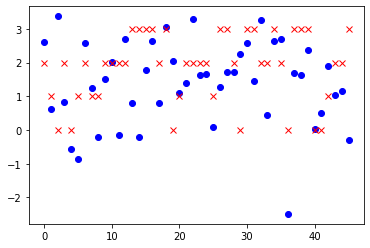

32.61 %


In [115]:
import matplotlib.pyplot as plt

quart = np.quantile(y_train_vali,[0.25, 0.5, 0.75])

y_test_class = np.digitize(y_test, quart)
yestClass = np.digitize(X_test@beta, quart)


plt.figure()
plt.plot(yestClass, 'ob')
plt.plot(y_test_class, 'xr')
plt.show()

print(np.sum(y_test_class==yestClass)/len(yestClass)*100, '%')

## Mínimos quadrados

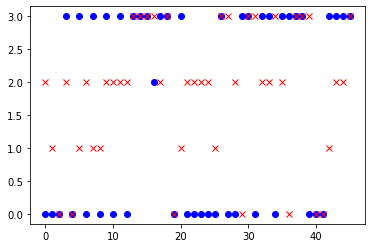

30.43 %


In [120]:
beta = ls(X_train_vali, y_train_vali)

y_test_class = np.digitize(y_test, quart)
yestClass = np.digitize(X_test@beta, quart)


plt.figure()
plt.plot(yestClass, 'ob')
plt.plot(y_test_class, 'xr')
plt.show()

print(np.round(np.sum(y_test_class==yestClass)/len(yestClass)*100,2), '%')

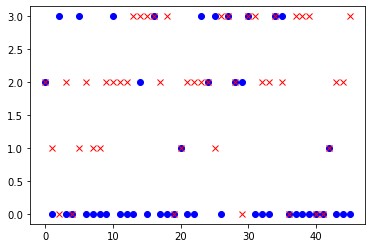

Age - 30.43 %
Age f1score -  0.32910628019323673


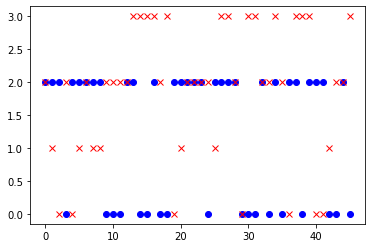

Gender - 21.74 %
Gender f1score -  0.11782608695652175


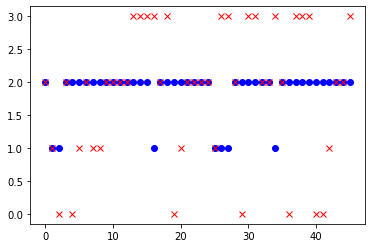

Height - 43.48 %
Height f1score -  0.22932330827067668


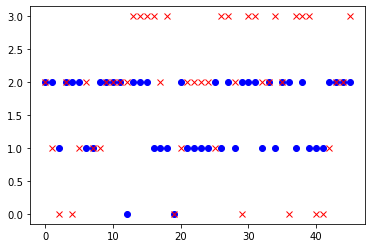

Weight - 23.91 %
Weight f1score -  0.17782828282828284


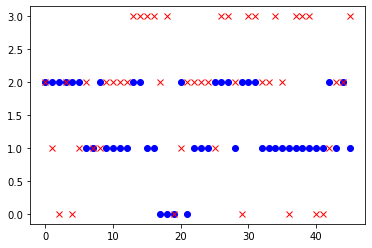

BMI - 10.87 %
BMI f1score -  0.10325024437927663


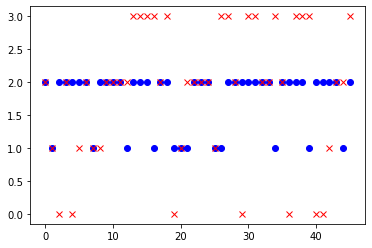

FootLen - 41.3 %
FootLen f1score -  0.2494939271255061


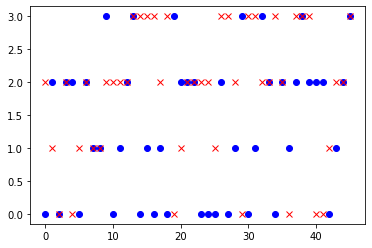

Ystudy - 30.43 %
Ystudy f1score -  0.27538515406162467


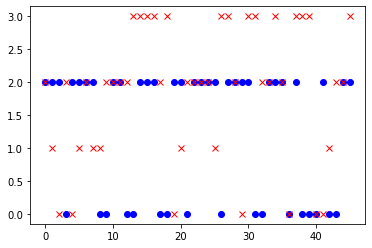

Illness - 28.26 %
Illness f1score -  0.15868794326241134


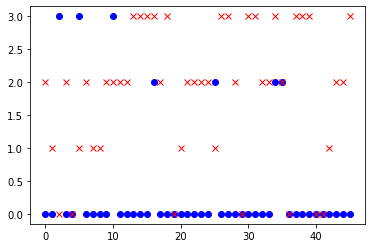

Nmedication - 15.22 %
Nmedication f1score -  0.08794466403162055


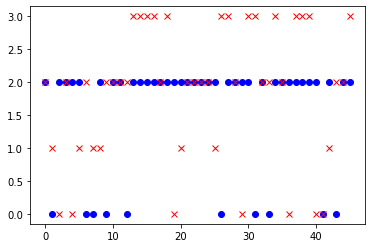

Ortho-Prosthesis - 30.43 %
Ortho-Prosthesis f1score -  0.14978213507625274


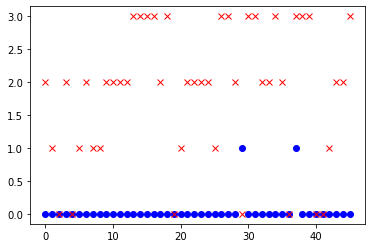

Disability - 13.04 %
Disability f1score -  0.0588235294117647


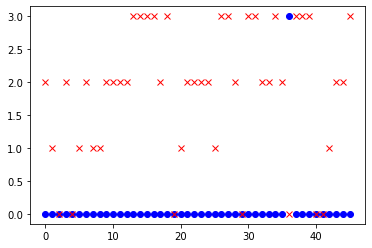

Falls12m - 13.04 %
Falls12m f1score -  0.057692307692307696


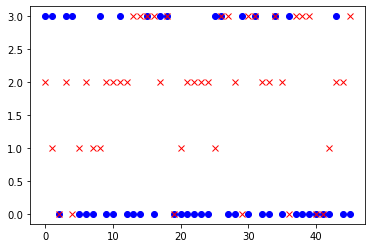

FES_1 - 19.57 %
FES_1 f1score -  0.13738738738738737


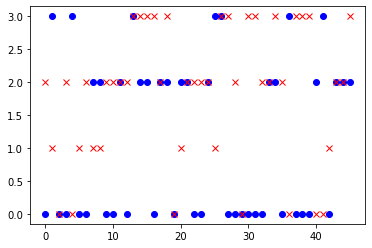

FES_2 - 26.09 %
FES_2 f1score -  0.20056022408963586


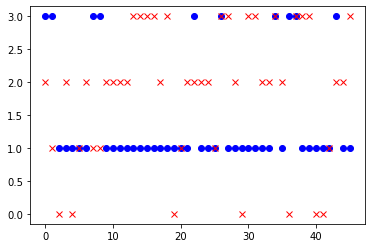

FES_3 - 15.22 %
FES_3 f1score -  0.10901162790697674


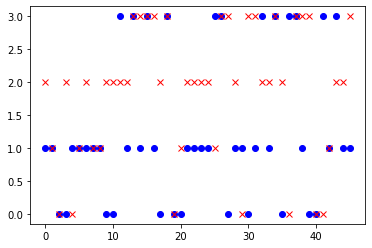

FES_4 - 30.43 %
FES_4 f1score -  0.2805388803573921


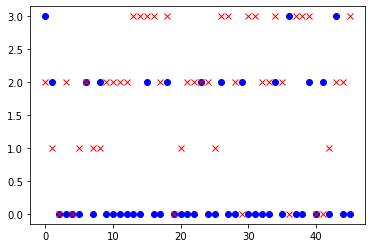

FES_5 - 13.04 %
FES_5 f1score -  0.08576480990274093


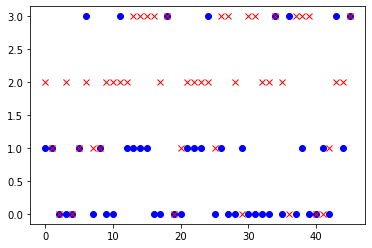

FES_6 - 21.74 %
FES_6 f1score -  0.2023647267275453


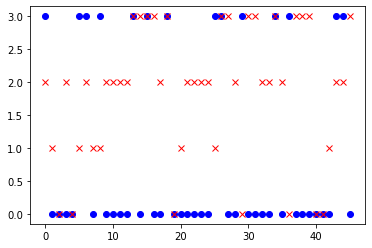

FES_7 - 21.74 %
FES_7 f1score -  0.1533882783882784


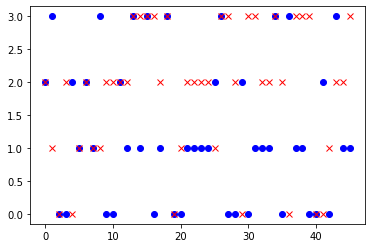

FES_T - 28.26 %
FES_T f1score -  0.28360248447204967


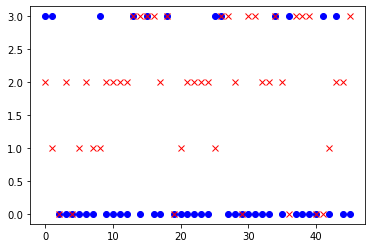

FES_S - 21.74 %
FES_S f1score -  0.1571294559099437


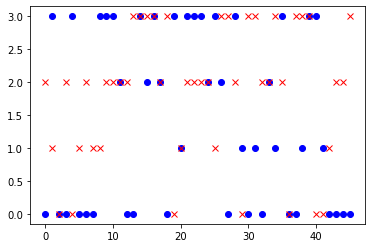

IPAQ_1a - 21.74 %
IPAQ_1a f1score -  0.21179487179487178


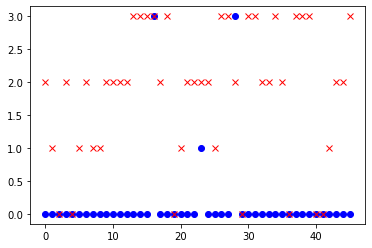

IPAQ_1b - 17.39 %
IPAQ_1b f1score -  0.10125


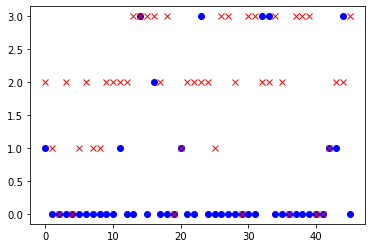

IPAQ_2a - 21.74 %
IPAQ_2a f1score -  0.1929824561403509


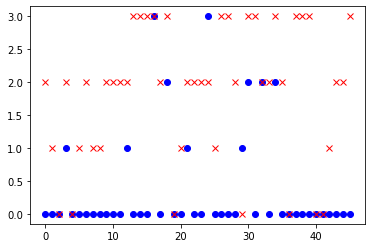

IPAQ_2b - 17.39 %
IPAQ_2b f1score -  0.12374471458773784


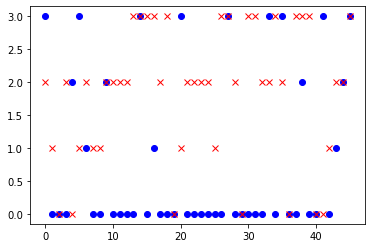

IPAQ_3a - 21.74 %
IPAQ_3a f1score -  0.17823950432646085


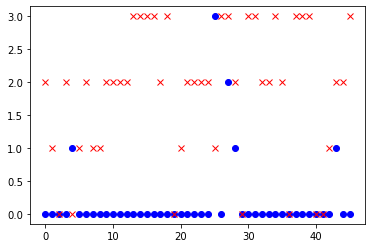

IPAQ_3b - 13.04 %
IPAQ_3b f1score -  0.0625


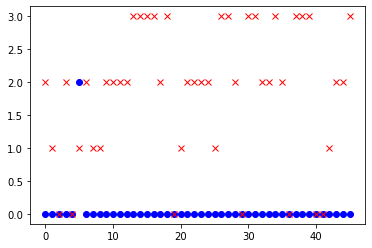

IPAQ_4a - 15.22 %
IPAQ_4a f1score -  0.06730769230769232


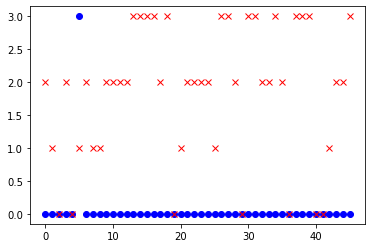

IPAQ_4b - 15.22 %
IPAQ_4b f1score -  0.06730769230769232


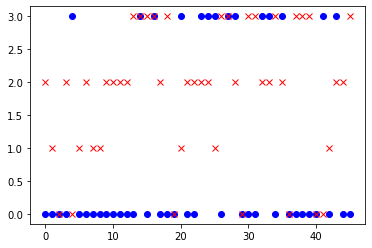

IPAQ_S - 17.39 %
IPAQ_S f1score -  0.11767399267399267


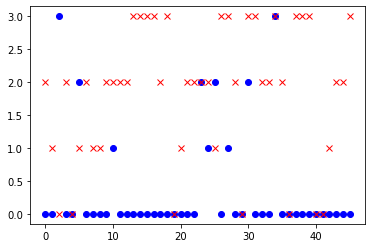

TMT_timeA - 17.39 %
TMT_timeA f1score -  0.12215909090909091


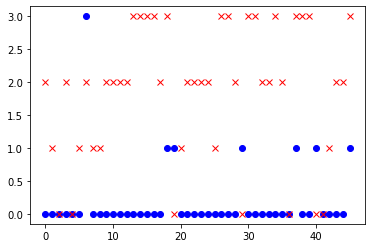

TMT_errorsA - 8.7 %
TMT_errorsA f1score -  0.043478260869565216


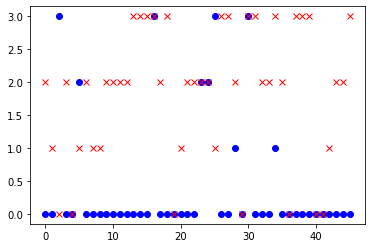

TMT_timeB - 21.74 %
TMT_timeB f1score -  0.17135642135642137


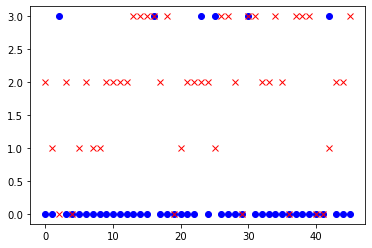

TMT_errorsB - 17.39 %
TMT_errorsB f1score -  0.11382978723404255


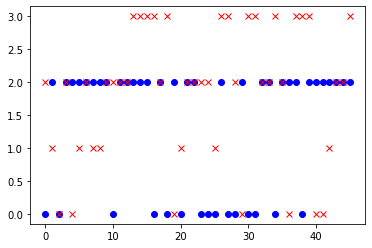

Best_2 - 30.43 %
Best_2 f1score -  0.15538033395176254


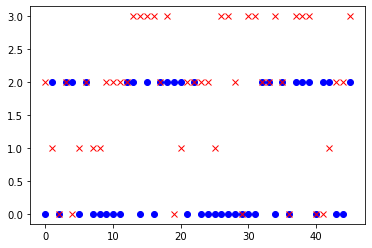

Best_3l - 26.09 %
Best_3l f1score -  0.16506410256410256


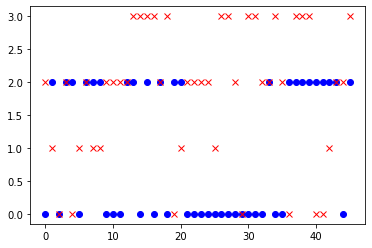

Best_3r - 17.39 %
Best_3r f1score -  0.10725806451612903


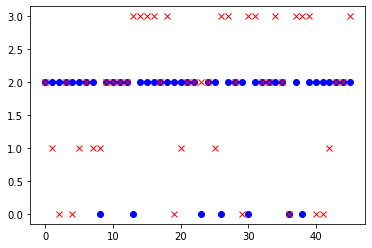

Best_4 - 39.13 %
Best_4 f1score -  0.18483709273182958


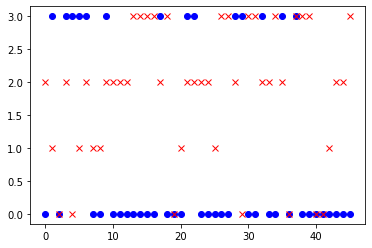

Best_5 - 13.04 %
Best_5 f1score -  0.08195970695970697


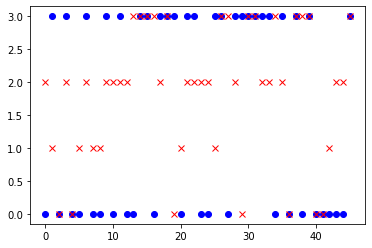

Best_6l - 30.43 %
Best_6l f1score -  0.2046279491833031


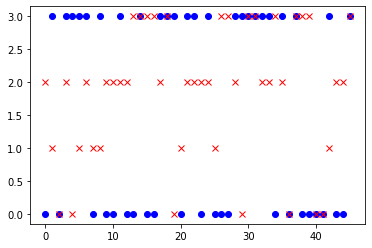

Best_6r - 21.74 %
Best_6r f1score -  0.14791288566243194


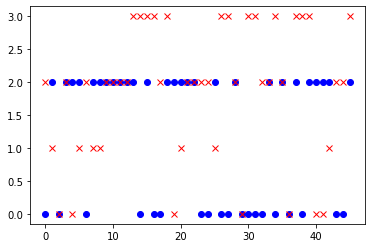

Best_8 - 28.26 %
Best_8 f1score -  0.16880341880341881


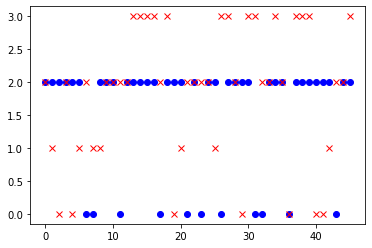

Best_9 - 26.09 %
Best_9 f1score -  0.13155136268343814


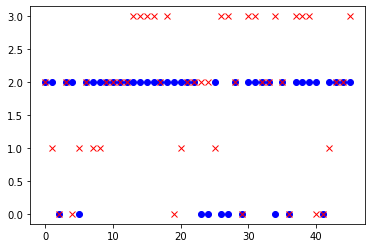

Best_11 - 43.48 %
Best_11 f1score -  0.2657952069716776


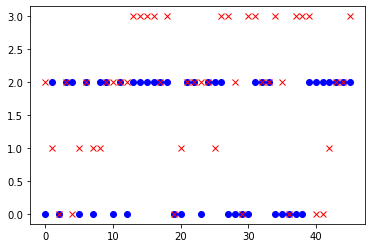

Best_12 - 34.78 %
Best_12 f1score -  0.21043478260869564


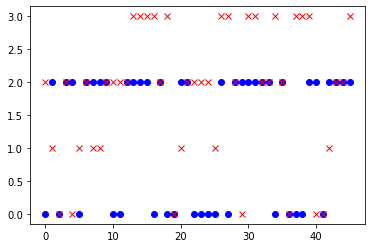

Best_13 - 34.78 %
Best_13 f1score -  0.21043478260869564


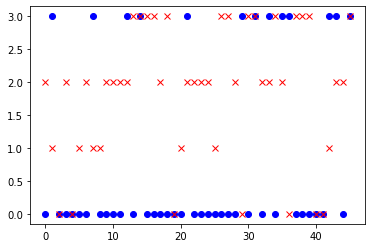

Best_14 - 17.39 %
Best_14 f1score -  0.11805555555555555


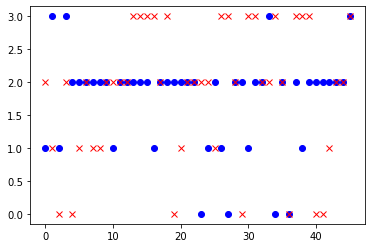

Best_T - 30.43 %
Best_T f1score -  0.19823232323232326


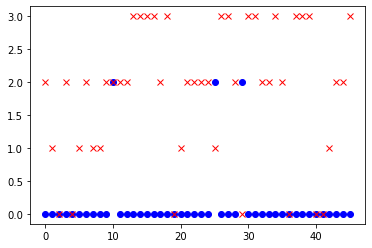

AngiotensinIIreceptorantagonist - 15.22 %
AngiotensinIIreceptorantagonist f1score -  0.0838095238095238


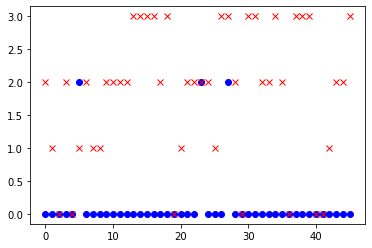

HMGCoAreductaseinhibitor - 17.39 %
HMGCoAreductaseinhibitor f1score -  0.09380952380952381


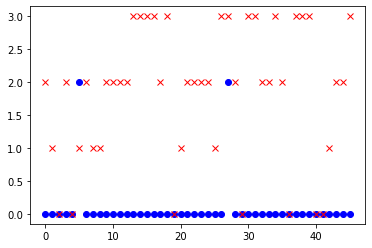

Hypercholesterolemia_total - 15.22 %
Hypercholesterolemia_total f1score -  0.06862745098039215


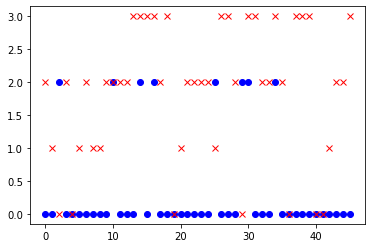

Hypertension_total - 13.04 %
Hypertension_total f1score -  0.07478632478632478


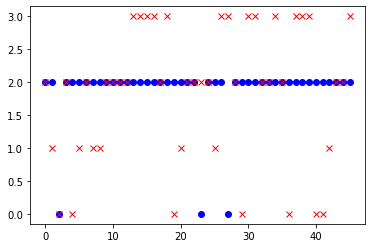

Normal Shoes_total - 39.13 %
Normal Shoes_total f1score -  0.18934426229508194


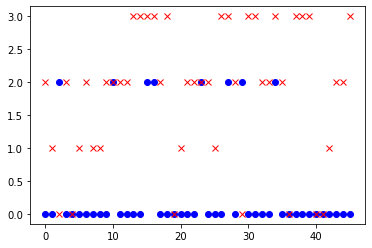

Sandal_FlipFlop_total - 15.22 %
Sandal_FlipFlop_total f1score -  0.09401709401709402


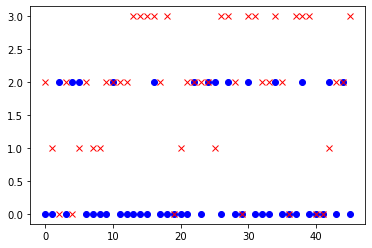

Dental_total - 19.57 %
Dental_total f1score -  0.1266025641025641


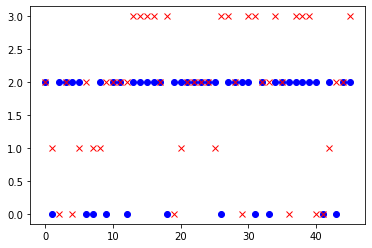

Corrective_lens - 30.43 %
Corrective_lens f1score -  0.15041928721174003


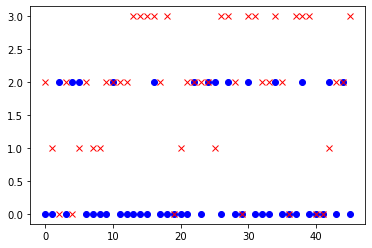

Hearing_dis_ortho_total - 19.57 %
Hearing_dis_ortho_total f1score -  0.1266025641025641


In [128]:
for i in range(X_train_vali.shape[1]):
    beta = ls(X_train_vali[:,[i]], y_train_vali)

    y_test_class = np.digitize(y_test, quart)
    yestClass = np.digitize(X_test[:,[i]]@beta, quart)


    plt.figure()
    plt.plot(yestClass, 'ob')
    plt.plot(y_test_class, 'xr')
    plt.show()

    print(features_names[i], '-', np.round(np.sum(y_test_class==yestClass)/len(yestClass)*100,2), '%')
    print(features_names[i], 'f1score - ', f1_score(y_test_class.squeeze(), yestClass.squeeze(), average='macro'))

## Random Forest

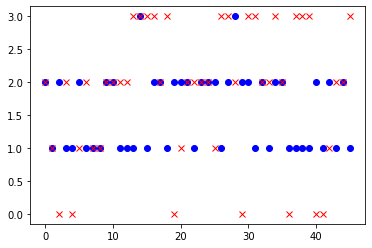

30.43 %


In [107]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=20, random_state=0)
regr.fit(X_train_vali, y_train_vali.squeeze())
yest = regr.predict(X_test)

y_test_class = np.digitize(y_test, quart)
yestClass = np.digitize(yest, quart)


plt.figure()
plt.plot(yestClass, 'ob')
plt.plot(y_test_class, 'xr')
plt.show()

print(np.round(np.sum(y_test_class.squeeze()==yestClass.squeeze())/len(yestClass)*100,2), '%')


## SVM

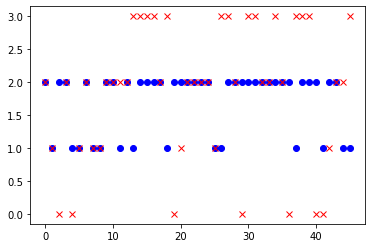

45.65 %


In [108]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

regr = make_pipeline(RobustScaler(), SVR(C=1.0, epsilon=0.1))
regr.fit(X_train_vali, y_train_vali.squeeze())

yest = regr.predict(X_test)

y_test_class = np.digitize(y_test, quart)
yestClass = np.digitize(yest, quart)


plt.figure()
plt.plot(yestClass, 'ob')
plt.plot(y_test_class, 'xr')
plt.show()

print(np.round(np.sum(y_test_class.squeeze()==yestClass.squeeze())/len(yestClass)*100,2), '%')


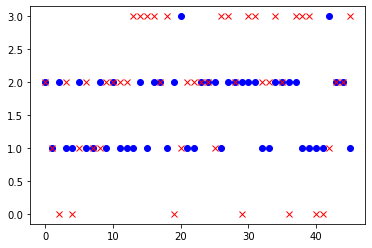

Age -  23.91 %
Age f1score -  0.14547038327526135


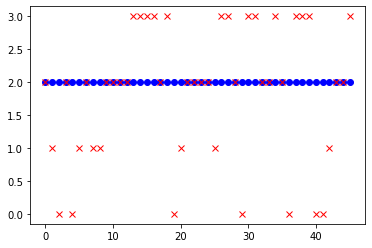

Gender -  39.13 %
Gender f1score -  0.140625


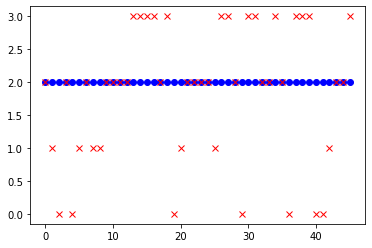

Height -  39.13 %
Height f1score -  0.140625


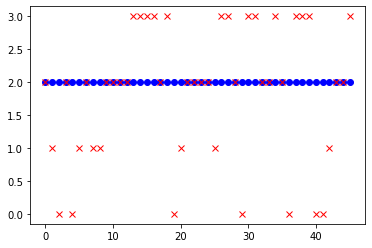

Weight -  39.13 %
Weight f1score -  0.140625


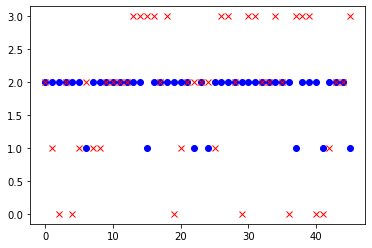

BMI -  32.61 %
BMI f1score -  0.13157894736842105


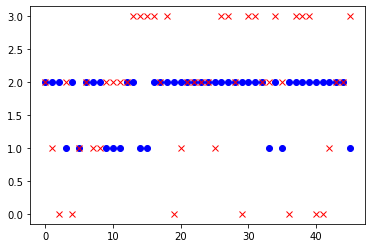

FootLen -  28.26 %
FootLen f1score -  0.14052287581699346


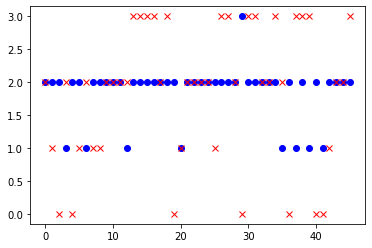

Ystudy -  32.61 %
Ystudy f1score -  0.1606060606060606


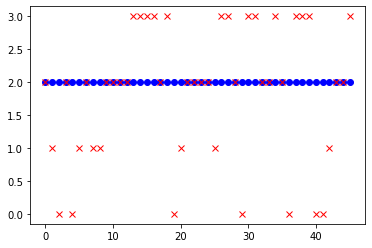

Illness -  39.13 %
Illness f1score -  0.140625


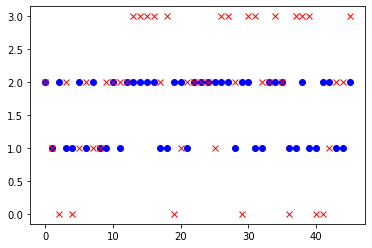

Nmedication -  21.74 %
Nmedication f1score -  0.12735042735042734


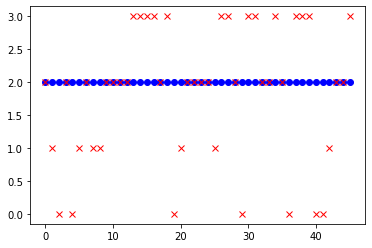

Ortho-Prosthesis -  39.13 %
Ortho-Prosthesis f1score -  0.140625


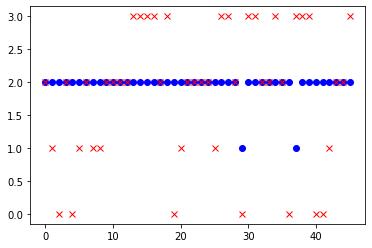

Disability -  39.13 %
Disability f1score -  0.14516129032258066


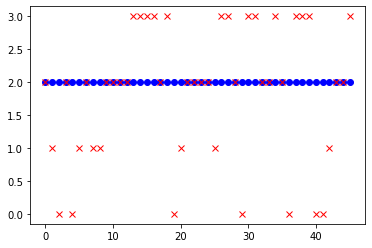

Falls12m -  39.13 %
Falls12m f1score -  0.140625


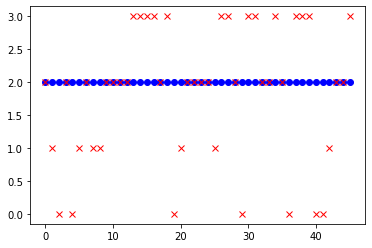

FES_1 -  39.13 %
FES_1 f1score -  0.140625


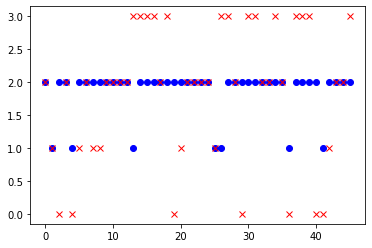

FES_2 -  43.48 %
FES_2 f1score -  0.22932330827067668


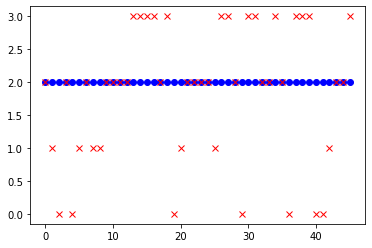

FES_3 -  39.13 %
FES_3 f1score -  0.140625


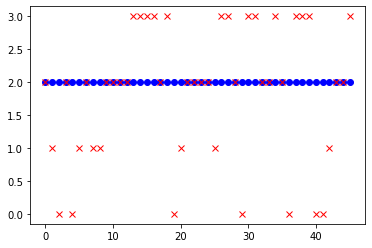

FES_4 -  39.13 %
FES_4 f1score -  0.140625


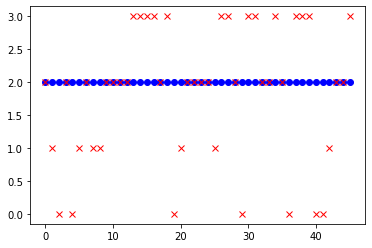

FES_5 -  39.13 %
FES_5 f1score -  0.140625


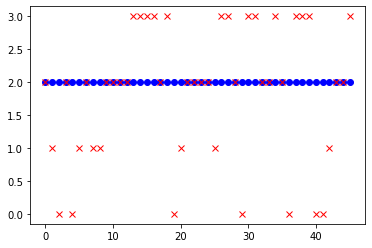

FES_6 -  39.13 %
FES_6 f1score -  0.140625


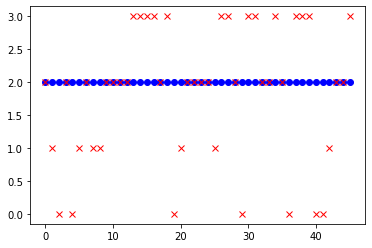

FES_7 -  39.13 %
FES_7 f1score -  0.140625


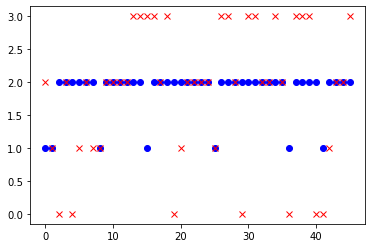

FES_T -  43.48 %
FES_T f1score -  0.25626566416040103


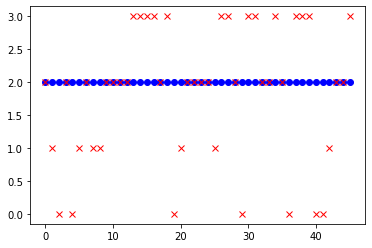

FES_S -  39.13 %
FES_S f1score -  0.140625


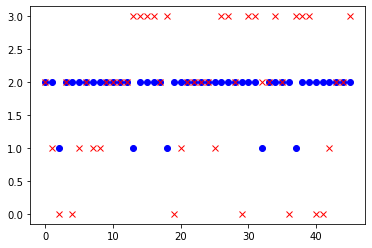

IPAQ_1a -  36.96 %
IPAQ_1a f1score -  0.1440677966101695


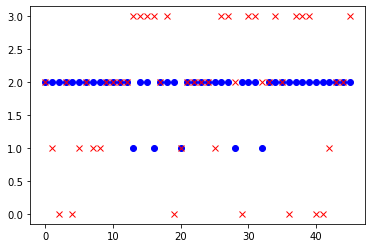

IPAQ_1b -  36.96 %
IPAQ_1b f1score -  0.17725988700564974


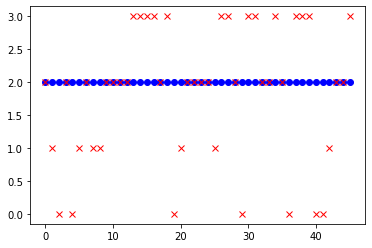

IPAQ_2a -  39.13 %
IPAQ_2a f1score -  0.140625


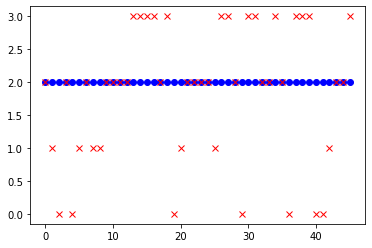

IPAQ_2b -  39.13 %
IPAQ_2b f1score -  0.140625


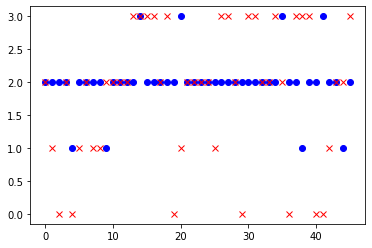

IPAQ_3a -  34.78 %
IPAQ_3a f1score -  0.16170634920634921


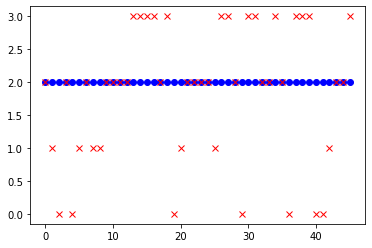

IPAQ_3b -  39.13 %
IPAQ_3b f1score -  0.140625


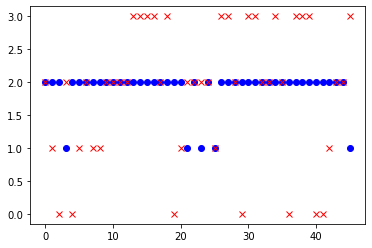

IPAQ_4a -  34.78 %
IPAQ_4a f1score -  0.16878531073446326


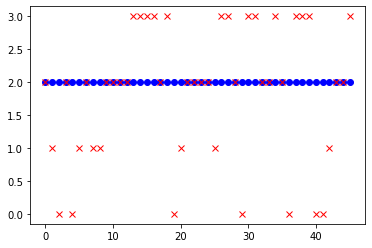

IPAQ_4b -  39.13 %
IPAQ_4b f1score -  0.140625


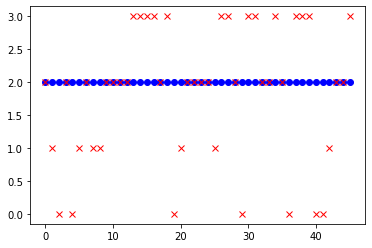

IPAQ_S -  39.13 %
IPAQ_S f1score -  0.140625


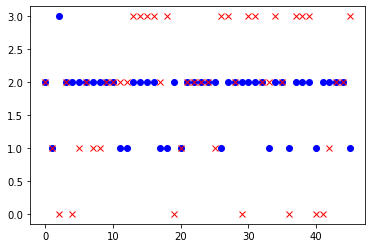

TMT_timeA -  34.78 %
TMT_timeA f1score -  0.19017094017094016


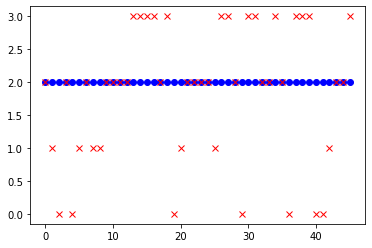

TMT_errorsA -  39.13 %
TMT_errorsA f1score -  0.140625


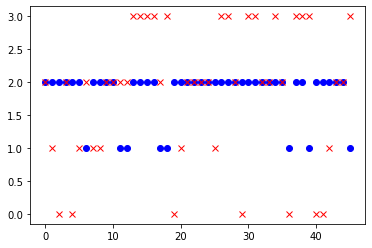

TMT_timeB -  30.43 %
TMT_timeB f1score -  0.125


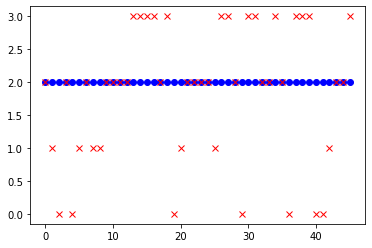

TMT_errorsB -  39.13 %
TMT_errorsB f1score -  0.140625


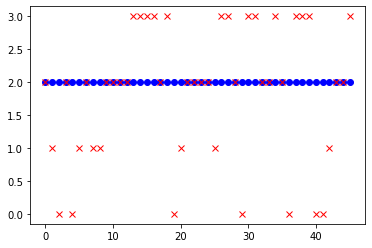

Best_2 -  39.13 %
Best_2 f1score -  0.140625


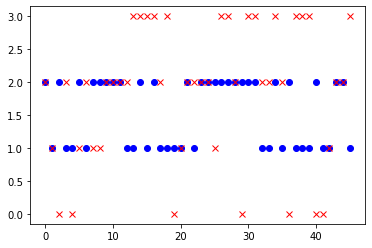

Best_3l -  28.26 %
Best_3l f1score -  0.16985049833887042


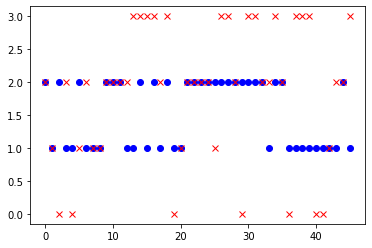

Best_3r -  36.96 %
Best_3r f1score -  0.229064039408867


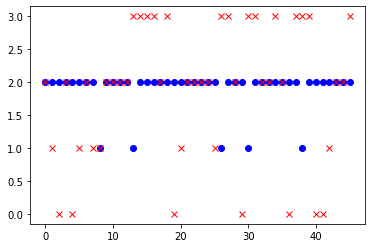

Best_4 -  41.3 %
Best_4 f1score -  0.1942090395480226


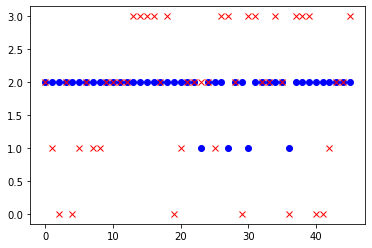

Best_5 -  36.96 %
Best_5 f1score -  0.14166666666666666


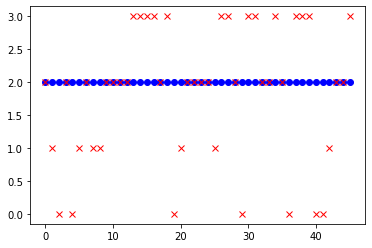

Best_6l -  39.13 %
Best_6l f1score -  0.140625


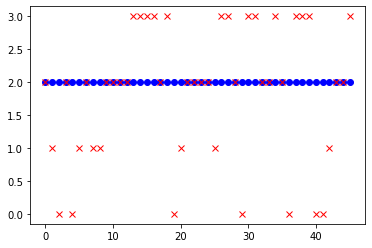

Best_6r -  39.13 %
Best_6r f1score -  0.140625


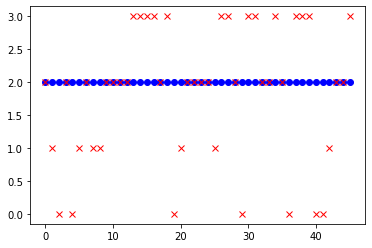

Best_8 -  39.13 %
Best_8 f1score -  0.140625


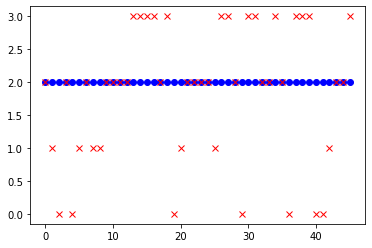

Best_9 -  39.13 %
Best_9 f1score -  0.140625


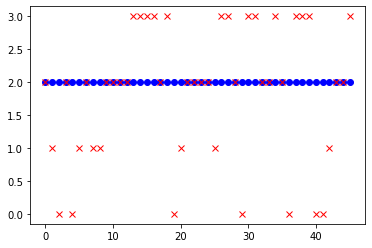

Best_11 -  39.13 %
Best_11 f1score -  0.140625


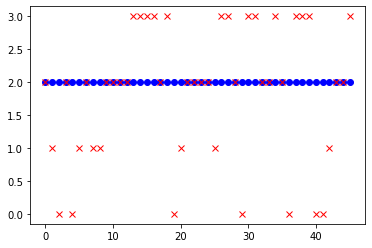

Best_12 -  39.13 %
Best_12 f1score -  0.140625


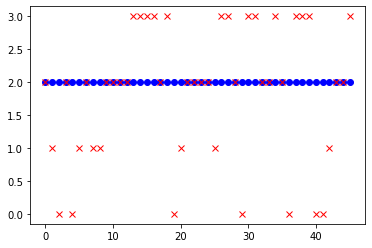

Best_13 -  39.13 %
Best_13 f1score -  0.140625


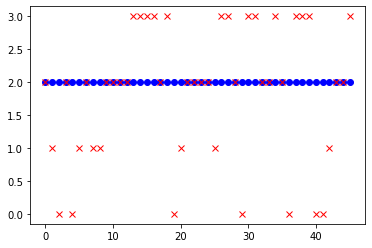

Best_14 -  39.13 %
Best_14 f1score -  0.140625


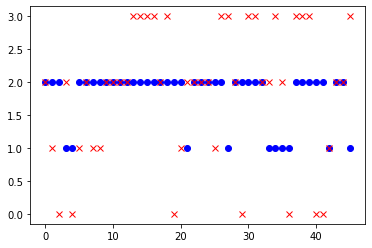

Best_T -  32.61 %
Best_T f1score -  0.15904139433551198


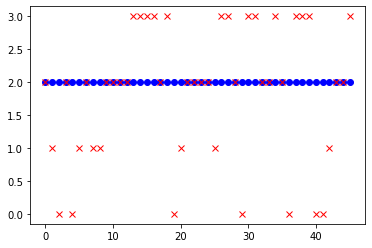

AngiotensinIIreceptorantagonist -  39.13 %
AngiotensinIIreceptorantagonist f1score -  0.140625


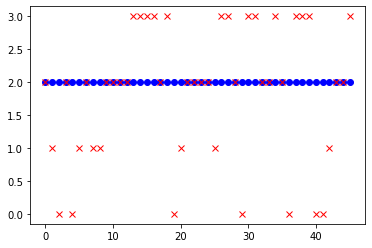

HMGCoAreductaseinhibitor -  39.13 %
HMGCoAreductaseinhibitor f1score -  0.140625


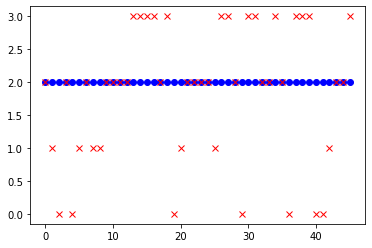

Hypercholesterolemia_total -  39.13 %
Hypercholesterolemia_total f1score -  0.140625


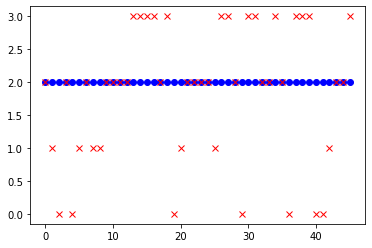

Hypertension_total -  39.13 %
Hypertension_total f1score -  0.140625


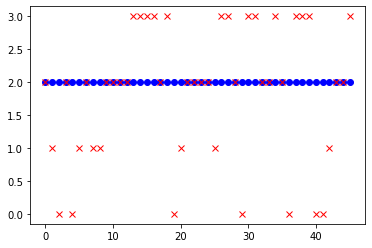

Normal Shoes_total -  39.13 %
Normal Shoes_total f1score -  0.140625


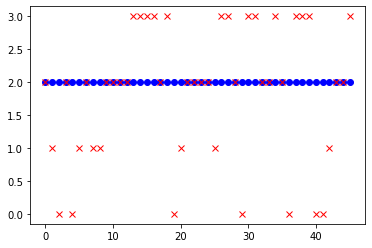

Sandal_FlipFlop_total -  39.13 %
Sandal_FlipFlop_total f1score -  0.140625


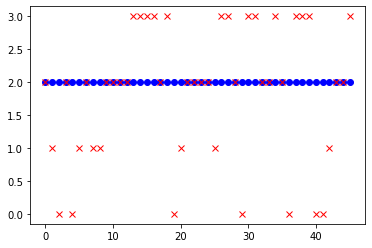

Dental_total -  39.13 %
Dental_total f1score -  0.140625


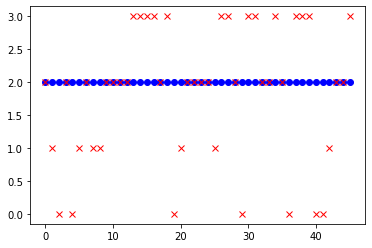

Corrective_lens -  39.13 %
Corrective_lens f1score -  0.140625


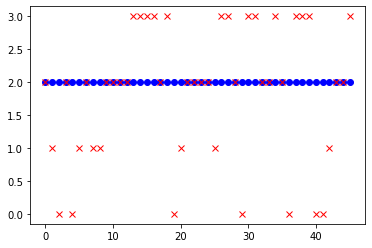

Hearing_dis_ortho_total -  39.13 %
Hearing_dis_ortho_total f1score -  0.140625


In [127]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score


for i in range(X_train_vali.shape[1]):
    regr = make_pipeline(RobustScaler(), SVR(C=1.0, epsilon=0.1))
    regr.fit(X_train_vali[:,[i]], y_train_vali.squeeze())

    yest = regr.predict(X_test[:,[i]])

    y_test_class = np.digitize(y_test, quart)
    yestClass = np.digitize(yest, quart)


    plt.figure()
    plt.plot(yestClass, 'ob')
    plt.plot(y_test_class, 'xr')
    plt.show()

    print(features_names[i], '- ', np.round(np.sum(y_test_class.squeeze()==yestClass.squeeze())/len(yestClass)*100,2), '%')
    print(features_names[i], 'f1score - ', f1_score(y_test_class.squeeze(), yestClass.squeeze(), average='macro'))